In [18]:
import requests as rq
import regex as re 
import chess.pgn
from io import StringIO

url = "https://api.chess.com/pub/player/MagnusCarlsen/games/2024/12"
headers = {
    "User-Agent": "Chess-me/1.0"
}

chess_moves_temp = rq.get(url = "https://api.chess.com/pub/player/magnuscarlsen/games/2024/12", headers=headers).json()['games'][1]['pgn']

pgn = StringIO(chess_moves_temp)  # Convertir le PGN en flux de texte
game = chess.pgn.read_game(pgn)

board = game.board()

# Compteur d'échanges
num_trades = 0

# Parcourir les coups de la partie
for move in game.mainline_moves():
    # Vérifier si le coup capture une pièce
    if board.is_capture(move):
        num_trades += 1  # Incrémenter le compteur si c'est un échange
    board.push(move)  # Appliquer le coup

num_trades


25

In [34]:
import chess.pgn
from io import StringIO

chess_moves_temp = rq.get(url = "https://api.chess.com/pub/player/magnuscarlsen/games/2024/12", headers=headers).json()['games'][1]['pgn']


class ChessAnalyzer:

    def __init__(self, pgn_data: str):
        """
        Initialise l'objet ChessAnalyzer avec une partie PGN.
        """
        pgn = StringIO(pgn_data)  # Convertir le PGN en flux de texte
        self.game = chess.pgn.read_game(pgn)  # Charger la partie

    def count_trades(self) -> int:
        """
        Compte le nombre d'échanges (captures) dans la partie.
        
        Returns:
            int: Nombre d'échanges de pièces.
        """
        board = chess.Board()
        num_trades = 0
        for move in self.game.mainline_moves():
            if board.is_capture(move):  # Vérifie si le coup capture une pièce
                num_trades += 1
            board.push(move)  # Appliquer le coup pour avancer la position
        
        return num_trades
    

    def game_length(self) -> int:
        """
        Retourne le nombre total de coups dans la partie.
        """
        return len(list(self.game.mainline_moves()))

    def queen_lifetime(self) -> int:
        """
        Retourne le nombre de coups pendant lesquels la reine reste sur l'échiquier.
        """
        board = chess.Board()
        queen_squares = {chess.D1, chess.D8}  # Cases initiales des reines
        move_count = 0
        for move in self.game.mainline_moves():
            if board.piece_at(move.to_square) and board.piece_at(move.to_square).piece_type == chess.QUEEN:
                queen_squares.discard(move.to_square)
            if not queen_squares:  # Les deux reines ont été prises
                break
            move_count += 1
            board.push(move)
        return move_count

    def central_pawns(self) -> int:
        """
        Retourne le nombre moyen de pions centraux présents dans la partie.
        """
        board = chess.Board()

        central_squares = {chess.D4, chess.D5, chess.E4, chess.E5}
        total_pawns = 0
        move_count = 0

        for move in self.game.mainline_moves():
            board.push(move)
            pawns = sum(1 for square in central_squares if board.piece_at(square) and board.piece_at(square).piece_type == chess.PAWN)
            total_pawns += pawns
            move_count += 1

        return total_pawns // max(1, move_count)

    def piece_advancement(self) -> int:
        """
        Retourne le nombre total de coups où une pièce avance dans le camp adverse.
        """
        board = chess.Board()
        advancement_count = 0
        for move in self.game.mainline_moves():
            rank = chess.square_rank(move.to_square)
            if (board.turn and rank >= 4) or (not board.turn and rank <= 3):
                advancement_count += 1
            board.push(move)
        return advancement_count

    def queen_moves(self) -> int:
        """
        Retourne le nombre de mouvements de la dame dans la partie.
        """
        board = chess.Board()
        queen_moves = 0
        for move in self.game.mainline_moves():
            piece = board.piece_at(move.from_square)
            if piece and piece.piece_type == chess.QUEEN:
                queen_moves += 1
            board.push(move)
        return queen_moves

    def castling_type(self) -> str:
        """
        Retourne le type de roque effectué par le joueur blanc.
        """
        board = chess.Board()
        white_king_side = False
        white_queen_side = False

        for move in self.game.mainline_moves():
            if board.is_castling(move):
                if board.turn and move.to_square in {chess.G1, chess.G8}:
                    white_king_side = True
                elif board.turn and move.to_square in {chess.C1, chess.C8}:
                    white_queen_side = True
            board.push(move)

        if white_king_side and white_queen_side:
            return "Both"
        elif white_king_side:
            return "King-side"
        elif white_queen_side:
            return "Queen-side"
        else:
            return "None"

    def piece_moves(self) -> dict:
        """
        Retourne le nombre de déplacements de chaque type de pièce.
        """
        board = chess.Board()
        piece_counts = {chess.PAWN: 0, chess.KNIGHT: 0, chess.BISHOP: 0, chess.ROOK: 0, chess.QUEEN: 0, chess.KING: 0}

        for move in self.game.mainline_moves():
            piece = board.piece_at(move.from_square)
            if piece:
                piece_counts[piece.piece_type] += 1
            board.push(move)

        return {
            "Pawns": piece_counts[chess.PAWN],
            "Knights": piece_counts[chess.KNIGHT],
            "Bishops": piece_counts[chess.BISHOP],
            "Rooks": piece_counts[chess.ROOK],
            "Queens": piece_counts[chess.QUEEN],
            "Kings": piece_counts[chess.KING],
        }

# Exemple d'utilisation
if __name__ == "__main__":
    pgn_data = chess_moves_temp  # PGN récupéré via l'API
    analyzer = ChessAnalyzer(pgn_data)
    # analyzer.display_game_info()

    print(f"Nombre d'échanges de pièces : {analyzer.count_trades()}")

    print(f"Longueur de la partie : {analyzer.game_length()} coups")
    print(f"Durée de vie de la dame : {analyzer.queen_lifetime()} coups")

    print(f"Nombre moyen de pions centraux : {analyzer.central_pawns()}")
    print(f"Nombre de déplacements vers l'avant : {analyzer.piece_advancement()}")
    print(f"Nombre de déplacements de la dame : {analyzer.queen_moves()}")
    print(f"Type de roque : {analyzer.castling_type()}")
    print(f"Nombre de mouvements par pièce : {analyzer.piece_moves()}")

    
    



Nombre d'échanges de pièces : 25
Longueur de la partie : 94 coups
Durée de vie de la dame : 94 coups
Nombre moyen de pions centraux : 0
Nombre de déplacements vers l'avant : 38
Nombre de déplacements de la dame : 1
Type de roque : King-side
Nombre de mouvements par pièce : {'Pawns': 26, 'Knights': 15, 'Bishops': 12, 'Rooks': 24, 'Queens': 1, 'Kings': 16}


import chess

board = chess.Board()

board.push_san("e4")

In [90]:
import chess.pgn

with open('Mamedyarov.pgn', 'r') as f:
    games = []
    for i in range(4500):
        try:
            game = chess.pgn.read_game(f)

            if 'Mamedyarov' in game.headers['White']:
                games.append(game)
            # print(game.headers['Event'])
        except:
            continue

print(game.headers['White'])


# board = game.board()
# for m in game.mainline_moves():
#     board.push(m)
#     print(str(board))
#     print('__________')

# board

# board

# game2.headers['Event']

Mamedyarov,S


In [92]:
import pickle as pkl

pkl.dump(games, open('mamedyarov_games.pkl', 'wb'))

In [96]:
board = game.board()

for m in games[1].mainline_moves():
    board.push(m)
    print(board)
    print('______')


r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . P . . . .
. . . . . . . .
P P P . P P P P
R N B Q K B N R
______
r n b q k b n r
p p p . p p p p
. . . . . . . .
. . . p . . . .
. . . P . . . .
. . . . . . . .
P P P . P P P P
R N B Q K B N R
______
r n b q k b n r
p p p . p p p p
. . . . . . . .
. . . p . . . .
. . . P . . . .
. . . . . N . .
P P P . P P P P
R N B Q K B . R
______
r n b q k b n r
p p p . . p p p
. . . . p . . .
. . . p . . . .
. . . P . . . .
. . . . . N . .
P P P . P P P P
R N B Q K B . R
______
r n b q k b n r
p p p . . p p p
. . . . p . . .
. . . p . . . .
. . . P . B . .
. . . . . N . .
P P P . P P P P
R N . Q K B . R
______
r n b q k b . r
p p p . . p p p
. . . . p n . .
. . . p . . . .
. . . P . B . .
. . . . . N . .
P P P . P P P P
R N . Q K B . R
______
r n b q k b . r
p p p . . p p p
. . . . p n . .
. . . p N . . .
. . . P . B . .
. . . . . . . .
P P P . P P P P
R N . Q K B . R
______
r n b q k b . r
p p . . . p p p
. . . . p n . .
. . p p

In [170]:
def board_to_matrix(board):
    piece_map = {
        chess.PAWN: 1, chess.KNIGHT: 2, chess.BISHOP: 3,
        chess.ROOK: 4, chess.QUEEN: 5, chess.KING: 6
    }
    matrix = np.zeros((8, 8), dtype=int)
    for square, piece in board.piece_map().items():
        x, y = divmod(square, 8)
        sign = 1 if piece.color == chess.WHITE else -1
        matrix[7 - x, y] = sign * piece_map[piece.piece_type]
    return matrix

dataset = []
for game in games:
    board = game.board()
    for move in game.mainline_moves():
        # if board.turn:
            before_board = board_to_matrix(board)
            before_board_chess = board.copy()
            board.push(move)
            after_board = board_to_matrix(board)
            after_board_chess = board.copy()
            if before_board_chess.turn: 
                dataset.append({"move_grid":(before_board, after_board), "board_before": before_board_chess, "board_after": after_board_chess, "move":move, "board":board.copy()})



In [175]:
len(dataset)

96514

In [174]:
with open('dataset_white_moves.pkl', 'wb') as f:
    pkl.dump(dataset, f)

In [166]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Architecture
model = models.Sequential([
    layers.Input(shape=(8, 8, 1)),  # Entrée: une matrice 8x8
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Flatten(),
    layers.Dense(8 * 8, activation='linear'),
    layers.Reshape((8, 8)),  # Sortie: matrice 8x8
])

# Compilation
model.compile(optimizer='adam', loss='mse')  # Perte MSE pour la régression


In [168]:
import numpy as np 

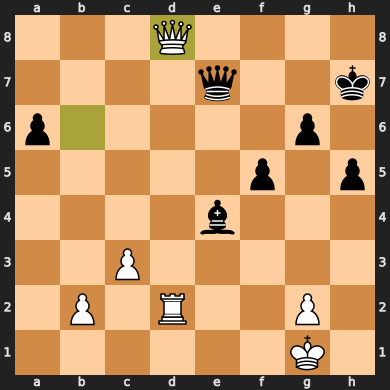

In [165]:
dataset[510]['board_after']

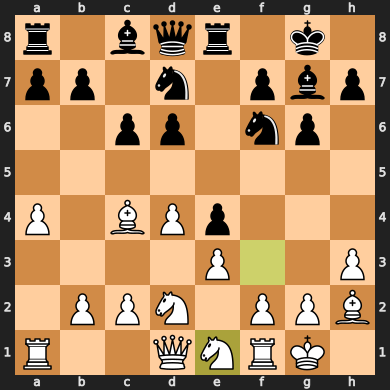

In [132]:
dataset[88]['board_after']

In [65]:
import chess

board = chess.Board()
board.push_san('Nf6')

print(board)

IllegalMoveError: illegal san: 'Nf6' in rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1

In [63]:
import time

moves = 'Nf6 Nf3 c5 d5 b5 Bg5 Qb6 a4 bxa4 Nc3 Qxb2 Nxa4 Qb4+ c3 Qe4 Nb6 Bb7 Nxa8 Bxa8 Qb1 Qxb1+ Rxb1 Na6 Bxf6 exf6 e4 Nc7 Rb8+ Ke7 Rc8 Kd6 Nd2'.split(' ')

board = chess.Board()

print(moves)

for m in moves:
    board.push_san(m)
    print(board)
    print('----------')
    time.sleep(0.5)

['Nf6', 'Nf3', 'c5', 'd5', 'b5', 'Bg5', 'Qb6', 'a4', 'bxa4', 'Nc3', 'Qxb2', 'Nxa4', 'Qb4+', 'c3', 'Qe4', 'Nb6', 'Bb7', 'Nxa8', 'Bxa8', 'Qb1', 'Qxb1+', 'Rxb1', 'Na6', 'Bxf6', 'exf6', 'e4', 'Nc7', 'Rb8+', 'Ke7', 'Rc8', 'Kd6', 'Nd2']


IllegalMoveError: illegal san: 'Nf6' in rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1

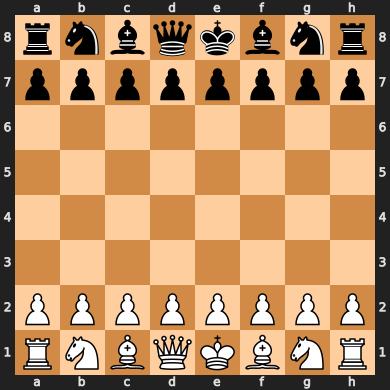

In [66]:
import numpy as np 

board